# XLA in Python

<img style="height:100px;" src="https://raw.githubusercontent.com/tensorflow/tensorflow/master/tensorflow/compiler/xla/g3doc/images/xlalogo.png"> <img style="height:100px;" src="https://upload.wikimedia.org/wikipedia/commons/c/c3/Python-logo-notext.svg">

_Anselm Levskaya_ 

XLA is the compiler that JAX uses, and the compiler that TF uses for TPUs and will soon use for all devices, so it's worth some study.  However, it's not exactly easy to play with XLA computations directly using the raw C++ interface.  JAX exposes the underlying XLA computation builder API through a python wrapper, and makes interacting with the XLA compute model accessible for messing around and prototyping.

XLA computations are built as computation graphs in HLO IR, which is then lowered to LLO that is device specific (CPU, GPU, TPU, etc.).  

As end users we interact with the computational primitives offered to us by the HLO spec.

## References 

__xla__: the doc that defines what's in HLO - but note that the doc is incomplete and omits some ops.

https://www.tensorflow.org/xla/operation_semantics

more details on ops in the source code.

https://github.com/tensorflow/tensorflow/blob/master/tensorflow/compiler/xla/client/xla_builder.h

__python xla client__:  this is the XLA python client for JAX, and what we're using here.

https://github.com/tensorflow/tensorflow/blob/master/tensorflow/compiler/xla/python/xla_client.py

https://github.com/tensorflow/tensorflow/blob/master/tensorflow/compiler/xla/python/xla_client_test.py

__jax__: you can see how jax interacts with the XLA compute layer for execution and JITing in these files.

https://github.com/google/jax/blob/master/jax/lax.py

https://github.com/google/jax/blob/master/jax/lib/xla_bridge.py

https://github.com/google/jax/blob/master/jax/interpreters/xla.py

## Colab Setup and Imports

In [0]:
# We import as onp to emphasize that we're using vanilla numpy, not jax numpy.
import numpy as onp

# We only need to import JAX's xla_client, not all of JAX.
from jaxlib import xla_client

# Plotting
import matplotlib as mpl
from matplotlib import pyplot as plt
from matplotlib import gridspec
from matplotlib import rcParams
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'viridis'
rcParams['axes.grid'] = False

## Convenience Functions

In [0]:
# Here we borrow convenience functions from JAX to convert numpy shape/dtypes
# to XLA appropriate shape/dtypes
def canonicalize_dtype(dtype):
  """We restrict ourselves to 32bit types for this demo."""
  _dtype_to_32bit_dtype = {
      str(onp.dtype('int64')): onp.dtype('int32'),
      str(onp.dtype('uint64')): onp.dtype('uint32'),
      str(onp.dtype('float64')): onp.dtype('float32'),
      str(onp.dtype('complex128')): onp.dtype('complex64'),
  }
  dtype = onp.dtype(dtype)
  return _dtype_to_32bit_dtype.get(str(dtype), dtype)

def shape_of(value):
  """Given a Python or XLA value, return its canonicalized XLA Shape."""
  if hasattr(value, 'shape') and hasattr(value, 'dtype'):
    return xla_client.Shape.array_shape(canonicalize_dtype(value.dtype), 
                                        value.shape)
  elif onp.isscalar(value):
    return shape_of(onp.asarray(value))
  elif isinstance(value, (tuple, list)):
    return xla_client.Shape.tuple_shape(tuple(shape_of(elt) for elt in value))
  else:
    raise TypeError('Unexpected type: {}'.format(type(value)))

def to_xla_type(dtype):
  "Convert to integert xla type, for use with ConvertElementType, etc."
  if isinstance(dtype, str):
    return xla_client.DTYPE_TO_XLA_ELEMENT_TYPE[dtype]
  elif isinstance(dtype, type):
    return xla_client.DTYPE_TO_XLA_ELEMENT_TYPE[onp.dtype(dtype).name]
  elif isinstance(dtype, onp.dtype):
    return xla_client.DTYPE_TO_XLA_ELEMENT_TYPE[dtype.name]
  else:
    raise TypeError('Unexpected type: {}'.format(type(dtype)))

## Simple Computations

In [0]:
# make a computation builder
c = xla_client.ComputationBuilder("simple_scalar")

# define a parameter shape and parameter
param_shape = xla_client.Shape.array_shape(onp.dtype(onp.float32), ())
x = c.ParameterWithShape(param_shape)

# define computation graph
y = c.Sin(x)

# build computation graph
# Keep in mind that incorrectly constructed graphs can cause 
# your notebook kernel to crash!
computation = c.Build()

# compile graph based on shape
compiled_computation = computation.Compile([param_shape,])

# define a host variable with above parameter shape
host_input = onp.array(3.0, dtype=onp.float32)

# place host variable on device and execute
device_input = xla_client.LocalBuffer.from_pyval(host_input)
device_out = compiled_computation.Execute([device_input ,])

# retrive the result
device_out.to_py()

array(0.14112, dtype=float32)

In [0]:
# same as above with vector type:

c = xla_client.ComputationBuilder("simple_vector")
param_shape = xla_client.Shape.array_shape(onp.dtype(onp.float32), (3,))
x = c.ParameterWithShape(param_shape)

# can also use this function to define a shape from an example:
#x = c.ParameterFromNumpy(onp.array([0.0, 0.0, 0.0], dtype=onp.float32))

# which is the same as using our convenience function above:
#x = c.ParameterWithShape(shape_of(onp.array([0.0, 0.0, 0.0], 
#                                            dtype=onp.float32)))

# chain steps by reference:
y = c.Sin(x)
z = c.Abs(y)
computation = c.Build()
compiled_computation = computation.Compile([param_shape,])

host_input = onp.array([3.0, 4.0, 5.0], dtype=onp.float32)

device_input = xla_client.LocalBuffer.from_pyval(host_input)
device_out = compiled_computation.Execute([device_input ,])

# retrive the result
device_out.to_py()

array([0.14112  , 0.7568025, 0.9589243], dtype=float32)

## Simple While Loop

In [0]:
# trivial while loop, decrement until 0
#   x = 5
#   while x > 0:
#     x = x - 1
#
in_shape = shape_of(5)

# body computation:
bcb = xla_client.ComputationBuilder("bodycomp")
x = bcb.ParameterWithShape(in_shape)
const1 = bcb.Constant(onp.int32(1))
y = bcb.Sub(x, const1)
body_computation = bcb.Build()

# test computation:
tcb = xla_client.ComputationBuilder("testcomp")
x = tcb.ParameterWithShape(in_shape)
const0 = tcb.Constant(onp.int32(0))
y = tcb.Gt(x, const0)
test_computation = tcb.Build()

# while computation:
wcb = xla_client.ComputationBuilder("whilecomp")
x = wcb.ParameterWithShape(in_shape)
wcb.While(test_computation, body_computation, x)
while_computation = wcb.Build()

# Now compile and execute:
compiled_computation = while_computation.Compile([in_shape,])

host_input = onp.array(5, dtype=onp.int32)

device_input = xla_client.LocalBuffer.from_pyval(host_input)
device_out = compiled_computation.Execute([device_input ,])

# retrive the result
device_out.to_py()

array(0, dtype=int32)

## While loops w. tuples - Newton's Method for sqrt

In [0]:
Xsqr = 2
guess = 1.0
converged_delta = 0.001
maxit = 1000

in_shape = shape_of((1.0, 1.0, 1))

# body computation:
# x_{i+1} = x_{i} - (x_i**2 - y) / (2 * x_i)
bcb = xla_client.ComputationBuilder("bodycomp")
intuple = bcb.ParameterWithShape(in_shape)
y = bcb.GetTupleElement(intuple, 0)
x = bcb.GetTupleElement(intuple, 1)
guard_cntr = bcb.GetTupleElement(intuple, 2)
new_x = bcb.Sub(x, bcb.Div(bcb.Sub(bcb.Mul(x, x), y), bcb.Add(x, x)))
result = bcb.Tuple(y, new_x, bcb.Sub(guard_cntr, bcb.Constant(onp.int32(1))))
body_computation = bcb.Build()

# test computation -- convergence and max iteration test
tcb = xla_client.ComputationBuilder("testcomp")
intuple = tcb.ParameterWithShape(in_shape)
y = tcb.GetTupleElement(intuple, 0)
x = tcb.GetTupleElement(intuple, 1)
guard_cntr = tcb.GetTupleElement(intuple, 2)
criterion = tcb.Abs(tcb.Sub(tcb.Mul(x, x), y))
# stop at convergence criteria or too many iterations
test = tcb.And(tcb.Gt(criterion, tcb.Constant(onp.float32(converged_delta))), 
               tcb.Gt(guard_cntr, tcb.Constant(onp.int32(0))))
test_computation = tcb.Build()

# while computation:
wcb = xla_client.ComputationBuilder("whilecomp")
intuple = wcb.ParameterWithShape(in_shape)
wcb.While(test_computation, body_computation, intuple)
while_computation = wcb.Build()

# Now compile and execute:
compiled_computation = while_computation.Compile([in_shape,])

y = onp.array(Xsqr, dtype=onp.float32)
x = onp.array(guess, dtype=onp.float32)
maxit = onp.array(maxit, dtype=onp.int32)

device_input = xla_client.LocalBuffer.from_pyval((y, x, maxit))
device_out = compiled_computation.Execute([device_input ,])

host_out = device_out.to_py()
print("square root of {y} is {x}".format(y=y, x=host_out[1]))

square root of 2.0 is 1.4142156839370728


## Calculate Symm Eigenvalues

Let's exploit the XLA QR implementation to solve some eigenvalues for symmetric matrices.  

This is the naive QR algorithm, without acceleration for closely-spaced eigenvalue convergence, nor any permutation to sort eigenvalues by magnitude.

sorted eigenvalues
[-1.190547   -0.91282177 -0.32339668 -0.14050038 -0.09441247  0.08265306
  0.49015656  0.731502    1.0677357   5.3513203 ]
sorted eigenvalues from numpy
[-1.1905469  -0.9128221  -0.32339665 -0.14050038 -0.09441243  0.08265309
  0.49015662  0.7315014   1.0677353   5.351319  ]
sorted error
[-1.1920929e-07  3.5762787e-07 -2.9802322e-08  0.0000000e+00
 -3.7252903e-08 -2.9802322e-08 -5.9604645e-08  5.9604645e-07
  3.5762787e-07  1.4305115e-06]


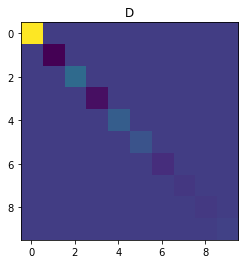

In [0]:
Niter = 200
matrix_shape = (10, 10)
in_shape = shape_of(
    (onp.zeros(matrix_shape, dtype=onp.float32), 1)
)
# NB: in_shape is the same as the manually constructed:
# xla_client.Shape.tuple_shape(
#      (xla_client.Shape.array_shape(onp.dtype(onp.float32), matrix_shape), 
#       xla_client.Shape.array_shape(onp.dtype(onp.int32), ()))
# )

# body computation -- QR loop: X_i = Q R , X_{i+1} = R Q
bcb = xla_client.ComputationBuilder("bodycomp")
intuple = bcb.ParameterWithShape(in_shape)
x = bcb.GetTupleElement(intuple, 0)
cntr = bcb.GetTupleElement(intuple, 1)
QR = bcb.QR(x)
Q = bcb.GetTupleElement(QR, 0)
R = bcb.GetTupleElement(QR, 1)
RQ = bcb.Dot(R, Q)
bcb.Tuple(RQ, bcb.Sub(cntr, bcb.Constant(onp.int32(1))))
body_computation = bcb.Build()

# test computation -- just a for loop condition
tcb = xla_client.ComputationBuilder("testcomp")
intuple = tcb.ParameterWithShape(in_shape)
cntr = tcb.GetTupleElement(intuple, 1)
test = tcb.Gt(cntr, tcb.Constant(onp.int32(0)))
test_computation = tcb.Build()

# while computation:
wcb = xla_client.ComputationBuilder("whilecomp")
intuple = wcb.ParameterWithShape(in_shape)
wcb.While(test_computation, body_computation, intuple)
while_computation = wcb.Build()

# Now compile and execute:
compiled_computation = while_computation.Compile([in_shape,])

X = onp.random.random(matrix_shape).astype(onp.float32)
X = (X + X.T) / 2.0
it = onp.array(Niter, dtype=onp.int32)

device_in = xla_client.LocalBuffer.from_pyval((X, it))
device_out = compiled_computation.Execute([device_in,])

host_out = device_out.to_py()
eigh_vals = host_out[0].diagonal()

plt.title('D')
plt.imshow(host_out[0])
print('sorted eigenvalues')
print(onp.sort(eigh_vals))
print('sorted eigenvalues from numpy')
print(onp.sort(onp.linalg.eigh(X)[0]))
print('sorted error') 
print(onp.sort(eigh_vals) - onp.sort(onp.linalg.eigh(X)[0]))

## Calculate Full Symm Eigensystem

We can also calculate the  eigenbasis by accumulating the Qs.

sorted eigenvalues
[-0.94551486 -0.63820213 -0.57944936 -0.28589356 -0.05510262  0.16862962
  0.4192178   0.4671099   0.88734317  4.990509  ]
sorted eigenvalues from numpy
[-0.9455159  -0.63820285 -0.5794492  -0.28589386 -0.05510259  0.16862962
  0.41921794  0.46710995  0.88734376  4.9905105 ]
sorted error
[ 1.0132790e-06  7.1525574e-07 -1.7881393e-07  2.9802322e-07
 -2.9802322e-08  0.0000000e+00 -1.4901161e-07 -5.9604645e-08
 -5.9604645e-07 -1.4305115e-06]


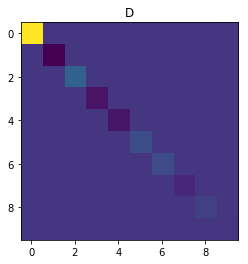

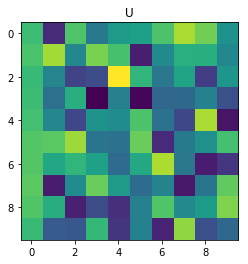

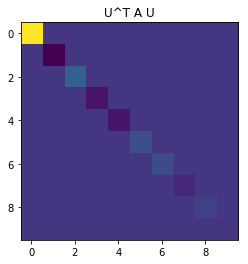

In [0]:
Niter = 100
matrix_shape = (10, 10)
in_shape = shape_of(
    (onp.zeros(matrix_shape, dtype=onp.float32), 
     onp.eye(matrix_shape[0]),
     1)
)

# body computation -- QR loop: X_i = Q R , X_{i+1} = R Q
bcb = xla_client.ComputationBuilder("bodycomp")
intuple = bcb.ParameterWithShape(in_shape)
X = bcb.GetTupleElement(intuple, 0)
O = bcb.GetTupleElement(intuple, 1)
cntr = bcb.GetTupleElement(intuple, 2)
QR = bcb.QR(X)
Q = bcb.GetTupleElement(QR, 0)
R = bcb.GetTupleElement(QR, 1)
RQ = bcb.Dot(R, Q)
Onew = bcb.Dot(O, Q)
bcb.Tuple(RQ, Onew, bcb.Sub(cntr, bcb.Constant(onp.int32(1))))
body_computation = bcb.Build()

# test computation -- just a for loop condition
tcb = xla_client.ComputationBuilder("testcomp")
intuple = tcb.ParameterWithShape(in_shape)
cntr = tcb.GetTupleElement(intuple, 2)
test = tcb.Gt(cntr, tcb.Constant(onp.int32(0)))
test_computation = tcb.Build()

# while computation:
wcb = xla_client.ComputationBuilder("whilecomp")
intuple = wcb.ParameterWithShape(in_shape)
wcb.While(test_computation, body_computation, intuple)
while_computation = wcb.Build()

# Now compile and execute:
compiled_computation = while_computation.Compile([in_shape,])

X = onp.random.random(matrix_shape).astype(onp.float32)
X = (X + X.T) / 2.0
Omat = onp.eye(matrix_shape[0], dtype=onp.float32)
it = onp.array(Niter, dtype=onp.int32)

device_in = xla_client.LocalBuffer.from_pyval((X, Omat, it))
device_out = compiled_computation.Execute([device_in,])

host_out = device_out.to_py()
eigh_vals = host_out[0].diagonal()
eigh_mat = host_out[1]

plt.title('D')
plt.imshow(host_out[0])
plt.figure()
plt.title('U')
plt.imshow(eigh_mat)
plt.figure()
plt.title('U^T A U')
plt.imshow(onp.dot(onp.dot(eigh_mat.T, X), eigh_mat))
print('sorted eigenvalues')
print(onp.sort(eigh_vals))
print('sorted eigenvalues from numpy')
print(onp.sort(onp.linalg.eigh(X)[0]))
print('sorted error') 
print(onp.sort(eigh_vals) - onp.sort(onp.linalg.eigh(X)[0]))

## Convolutions

I keep hearing from the AGI folks that we can use convolutions to build artificial life.  Let's try it out.

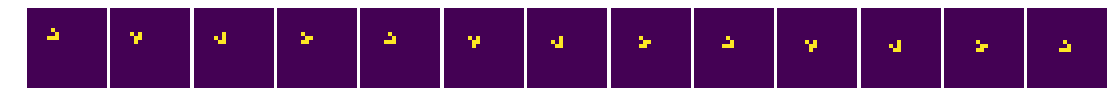

In [0]:
Niter=13
matrix_shape = (1,1, 20, 20)
in_shape = shape_of(
    (onp.zeros(matrix_shape, dtype=onp.int32), 1)
)

# Body computation -- Conway Update
bcb = xla_client.ComputationBuilder("bodycomp")
intuple = bcb.ParameterWithShape(in_shape)
x = bcb.GetTupleElement(intuple, 0)
cntr = bcb.GetTupleElement(intuple, 1)
# convs require floating-point type
xf = bcb.ConvertElementType(x, to_xla_type('float32'))
stamp = bcb.Constant(onp.ones((1,1,3,3), dtype=onp.float32))
convd = bcb.Conv(xf, stamp, onp.array([1, 1]), xla_client.PaddingType.SAME)
# logic ops require integer types
convd = bcb.ConvertElementType(convd, to_xla_type('int32'))
bool_x = bcb.Eq(x, bcb.ConstantS32Scalar(1))
# core update rule
res = bcb.Or(
    # birth rule
    bcb.And(bcb.Not(bool_x), bcb.Eq(convd, bcb.ConstantS32Scalar(3))),
    # survival rule
    bcb.And(bool_x, bcb.Or(
        # these are +1 the normal numbers since conv-sum counts self
        bcb.Eq(convd, bcb.ConstantS32Scalar(4)),
        bcb.Eq(convd, bcb.ConstantS32Scalar(3)))
    )
)
# Convert output back to int type for type constancy
int_res = bcb.ConvertElementType(res, to_xla_type('int32'))
bcb.Tuple(int_res, bcb.Sub(cntr, bcb.ConstantS32Scalar(1)))
body_computation = bcb.Build()

# Test computation -- just a for loop condition
tcb = xla_client.ComputationBuilder("testcomp")
intuple = tcb.ParameterWithShape(in_shape)
cntr = tcb.GetTupleElement(intuple, 1)
test = tcb.Gt(cntr, tcb.ConstantS32Scalar(0))
test_computation = tcb.Build()

# While computation:
wcb = xla_client.ComputationBuilder("whilecomp")
intuple = wcb.ParameterWithShape(in_shape)
wcb.While(test_computation, body_computation, intuple)
while_computation = wcb.Build()

# Now compile and execute:
compiled_computation = while_computation.Compile([in_shape,])

# Set up initial state
X = onp.zeros(matrix_shape, dtype=onp.int32)
X[0,0, 5:8, 5:8] = onp.array([[0,1,0],[0,0,1],[1,1,1]])

# Evolve
movie = onp.zeros((Niter,)+matrix_shape[-2:], dtype=onp.int32)
for it in range(Niter):
  itr = onp.array(it, dtype=onp.int32)
  device_in = xla_client.LocalBuffer.from_pyval((X, itr))
  device_out = compiled_computation.Execute([device_in,])
  movie[it] = device_out.to_py()[0][0,0]

# Plot
fig = plt.figure(figsize=(15,2))
gs = gridspec.GridSpec(1,Niter)
for i in range(Niter):
  ax1 = plt.subplot(gs[:, i])
  ax1.axis('off')
  ax1.imshow(movie[i])
plt.subplots_adjust(left=0.0, right=1.0, top=1.0, bottom=0.0, hspace=0.0, wspace=0.05)

## Fin 

There's much more to XLA, but this hopefully highlights how easy it is to play with via the python client!